# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы . Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Данные уже предобработаны.

Необходимо построить модель с максимально большим значением *accuracy*. Доля правильных ответов должна быть крайней не меньше 0.75.

**План работы:**
1. Открыть файл с данными и изучите его.
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры.
4. Проверить качество модели на тестовой выборке.
5. Проверить модель на вменяемость.
6. Общие выводы.

## 1. Откроем и изучим файл

In [1]:
#импорт библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
users = pd.read_csv(r'C:\\dataset_praktikum/users_behavior.csv') # чтение файла

In [3]:
users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Опишем данные:

*сalls* — количество звонков,  
*minutes* — суммарная длительность звонков в минутах,  
*messages* — количество sms-сообщений,  
*mb_used* — израсходованный интернет-трафик в Мб,  
*is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  

In [4]:
users.info() # основная информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
users.describe() # основная статистическая информация

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
users.duplicated().sum() # проверка на дубликаты

0

Посомтрим на корреляцию в данных. Оценим мультиколлинеарность признаков.

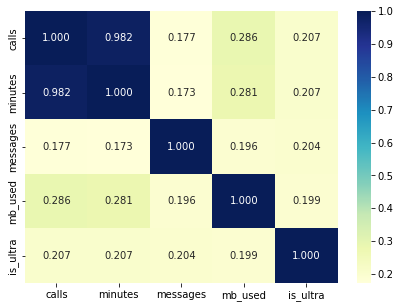

In [7]:
plt.figure(figsize=(7, 5))
sns.heatmap(users.corr(), annot = True, fmt = '0.3f', cmap="YlGnBu")
plt.show()

Два признака (calls и minutes) сильно коррелируют между собой (коэффициент корреляции = 0,982). Для лучшей работы моделей удалим один из них (calls).

In [8]:
users = users.drop(['calls'], axis=1)

### Вывод по шагу №1

На данном этапе загружены и изучены данные. Данные представленны в предобработанном виде. Пропущенных значений и дупликатов нет. Удален один мультиколлинеарный признак (calls).

## 2. Разделим данные на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

Посмотрим, как соотносятся классы для нашего набора данных.

In [9]:
users.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

<font color="blue">Классы не сбалансированные. Будем использовать параметр stratify = y в функции train_test_split( ), где y – соответствующая целевая переменная. Данные разделятся на два кластера (наблюдения класса 0 и наблюдения класса 1), и в валидационную/тестовую выборку попадут по 20% наблюдений из каждого кластера.
</font>

In [10]:
features = users.drop(['is_ultra'], axis=1) # извлечем признаки 
target = users['is_ultra'] # извлечем зависимую переменную
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
features, target, test_size=0.2, random_state=0, stratify = target) # отделим 20% данных для тестовой выборки
# отделим 25% (20% от общего количества) данных для валидационной выборки
features_train, features_valid, target_train, target_valid = train_test_split(
features_train_valid, target_train_valid, test_size=0.25, random_state=0, stratify = target_train_valid)

In [11]:
# стандартизируем данные
scaler = StandardScaler() # функция стандартизации
scaler.fit(features_train) # обучим StandartScaler на обучающей выборке
# Преобразуем обучающий и валидационные наборы данных
features_train_st = scaler.transform(features_train)
features_valid_st = scaler.transform(features_valid)
features_test_st = scaler.transform(features_test)

## 3. Исследуем модели

Обучим модели (параметры по умолчанию): дерево решений, случайный лес и логистическая регрессия.  
Вычислим метрики на валидационной выборке: accuracy, precision, recall и F1.  
Выберем лучшую модель.

In [12]:
metric_data = pd.DataFrame()
for model, name in zip([DecisionTreeClassifier(random_state = 0),
                        RandomForestClassifier(random_state = 0),
                        LogisticRegression(random_state = 0)],
                       ['Дерево решений', 'Случайный лес', 'Логистическая регрессия']):
    model.fit(features_train_st, target_train) # обучим модель на тренировочной выборке
    predictions = model.predict(features_valid_st) # получим предсказания модели на валидационной выборке
    accuracy = round(accuracy_score(target_valid, predictions),3)
    precision = round(precision_score(target_valid, predictions),3)
    recall = round(recall_score(target_valid, predictions),3)
    f1 = round(f1_score(target_valid, predictions),3)
    data = pd.DataFrame({'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1},
                       index=[name])
    metric_data = metric_data.append(data)

In [13]:
metric_data

,accuracy,precision,recall,f1
Дерево решений,0.720,0.540,0.589,0.563
Случайный лес,0.793,0.698,0.574,0.630
Логистическая регрессия,0.745,0.811,0.218,0.344


<font color="blue">Метрики RandomForestClassifier лучше.</font>

Попытаемся улучшить модель случайного леса путем подбора гиперпараметров.

In [14]:
n_estimators = list(range(10,500,10)) # число деревьев
max_depth = list(range(1,6)) # максимальная глубина деревьев
min_samples_split = [2,3,4] # минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
param = {'n_estimators': n_estimators,
         'max_depth': max_depth,
         'min_samples_split': min_samples_split,
         }

In [15]:
rs = RandomizedSearchCV(RandomForestClassifier(random_state = 0),param, n_iter = 10, cv = 3, n_jobs=-1, random_state=0)
rs.fit(features_train_st, target_train)
print('Лучшие параметры модели RandomForestClassifier:')
print(rs.best_params_)

Лучшие параметры модели RandomForestClassifier:
{'n_estimators': 340, 'min_samples_split': 4, 'max_depth': 5}


In [16]:
model_rf = RandomForestClassifier(random_state = 0, n_estimators = 480, min_samples_split = 3, max_depth = 3)
model_rf.fit(features_train_st, target_train) # обучим модель на тренировочной выборке
predictions_valid_rf = model_rf.predict(features_valid_st) # получим предсказания модели на валидационной выборке
print('Метрика accuracy модели RandomForestClassifier до подбора параметров = ', metric_data.accuracy[1])
print('Метрика accuracy модели RandomForestClassifier после подбора параметров = ', round(accuracy_score(target_valid, predictions_valid_rf),3))

Метрика accuracy модели RandomForestClassifier до подбора параметров =  0.793
Метрика accuracy модели RandomForestClassifier после подбора параметров =  0.807


### Вывод по шагу №3 (исследование моделей)

С параметрами по умолчанию модель случайного леса показала себя лучше моделей логистической регрессии и дерева решений.  
После подбора гиперпараметров метрика accuracy модели RandomForestClassifier увеличилась с  0.781 до 0,807.

## 4. Проверим модель на тестовой выборке

In [17]:
features_train_valid_st = scaler.transform(features_train_valid)
model_rf2 = RandomForestClassifier(random_state = 0, n_estimators = 480, min_samples_split = 3, max_depth = 3)
model_rf2.fit(features_train_valid_st, target_train_valid) # обучим модель на тренировочной+валидационной выборке
predictions_test_rf1 = model_rf2.predict(features_test_st) # получим предсказания модели на тестовой выборке
print('Модель RandomForestClassifier обучена на train+valid выборке.')
print('Метрика accuracy модели RandomForestClassifier на тестовой выборке = ', round(accuracy_score(target_test, predictions_test_rf1),3))

Модель RandomForestClassifier обучена на train+valid выборке.
Метрика accuracy модели RandomForestClassifier на тестовой выборке =  0.792


In [18]:
print('Модель RandomForestClassifier обучена на train выборке.')
predictions_test_rf2 = model_rf.predict(features_test_st) # получим предсказания модели на тестовой выборке
print('Метрика accuracy модели RandomForestClassifier на тестовой выборке = ', round(accuracy_score(target_test, predictions_test_rf2),3))

Модель RandomForestClassifier обучена на train выборке.
Метрика accuracy модели RandomForestClassifier на тестовой выборке =  0.802


<font color="blue">Метрика accuracy модели RandomForestClassifier на тестовой выборке не сильно отличается от метрики на валидационной выборке. Можно сделать вывод, что модель обучена хорошо (нет переобучения).</font>

## 5. Проверим модель на адекватность

Вычислим accuracy модели, которая, например, всегда предсказывает 0 (тариф "Смарт").

In [19]:
round(len(users.query('is_ultra==0'))/len(users),3)

0.694

<font color="blue">Обученная модель RandomForestClassifier с подобранными гиперпараметрами получилась адекватной, т.к. число правильных ответов у нее выше, чем у простой модели, предсказывающей всегда один класс.  </font>

In [20]:
users['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

## 6. Общие выводы

Выбрана и обучена модель RandomForestClassifier.

Подобраны лучшие гиперпараметры:  
random_state = 0, n_estimators = 480, min_samples_split = 3, max_depth = 3  
После подбора гиперпараметров метрика accuracy модели RandomForestClassifier увеличилась с 0.781 до 0,807.

Accuracy модели на валидационной выборке = 0,807  
Accuracy модели на тестовой выборке = 0,802

Необходимо обратить внимание на несбаланисрованность классов в данных - 70/30.